In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

import copy
import random

from ECGDataset import ECGDataset

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_ds = ECGDataset("data/mit_bih.csv")
test_ds = ECGDataset("data/mit_bih_test.csv")
val_ds = ECGDataset("data/mit_bih_val.csv")


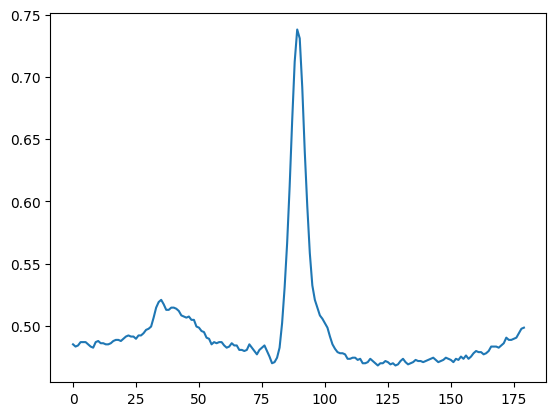

In [4]:
plt.plot(train_ds.df[2341])

In [5]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    val_losses = []

    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset)

    size = len(train_dl.dataset)
    for batch, X in enumerate(train_dl):
        # Compute prediction and loss
        X = X.to(device)
        pred = model(X)
        loss = criterion(pred, X)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    with torch.no_grad():  # requesting pytorch to record any gradient for this block of code
      for seq_true in val_dl:
        seq_true = seq_true.to(device)   # putting sequence to gpu
        seq_pred = model(seq_true)       # prediction

        loss = criterion(seq_pred, seq_true)  # recording loss

        val_losses.append(loss.item())    # storing loss into the validation losses

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss = {train_loss}, val loss = {val_loss}')

  return model.eval(), history

In [6]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(180, 1, device, 32)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [7]:
model, history = train_model(
  model, 
  train_dataset=train_ds, 
  val_dataset=val_ds,
  n_epochs=10,
  lr=1e-5,
  batch_size=1
)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 180, 1])) that is different to the input size (torch.Size([180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


loss: 77.347137  [    1/112551]
loss:     nan  [10001/112551]
loss:     nan  [20001/112551]
loss:     nan  [30001/112551]


KeyboardInterrupt: 

In [15]:
torch.save(model, "models/lstmae_5000")

In [69]:
torch.load("models/lstmae_5000", map_location=torch.device('cpu'))

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [31]:
model = model.to(device="cpu")

In [36]:
ds.__getitem__(0)

tensor([[0.5807],
        [0.5795],
        [0.5819],
        [0.5807],
        [0.5843],
        [0.5819],
        [0.5819],
        [0.5807],
        [0.5807],
        [0.5843],
        [0.5867],
        [0.5831],
        [0.5807],
        [0.5783],
        [0.5807],
        [0.5831],
        [0.5843],
        [0.5867],
        [0.5892],
        [0.5880],
        [0.5880],
        [0.5892],
        [0.5940],
        [0.5940],
        [0.5928],
        [0.6000],
        [0.6012],
        [0.6048],
        [0.6060],
        [0.6048],
        [0.6024],
        [0.5988],
        [0.6012],
        [0.6000],
        [0.6000],
        [0.6000],
        [0.5988],
        [0.5976],
        [0.5964],
        [0.5976],
        [0.6012],
        [0.6036],
        [0.6048],
        [0.5952],
        [0.5855],
        [0.5855],
        [0.5819],
        [0.5795],
        [0.5747],
        [0.5747],
        [0.5759],
        [0.5783],
        [0.5771],
        [0.5783],
        [0.5759],
        [0

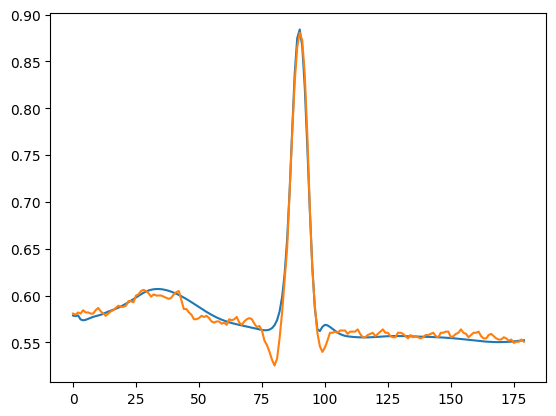

In [37]:
plt.plot(model(ds.__getitem__(0)).cpu().detach().numpy().squeeze())
plt.plot(ds.__getitem__(0).cpu().detach().numpy().squeeze())